In [3]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from keras.optimizers import Adam, SGD
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator

import warnings
import numpy as np
import cv2
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint, EarlyStopping
warnings.simplefilter(action='ignore', category=FutureWarning)


background = None
accumulated_weight = 0.5

#Creating the dimensions for the ROI...
ROI_top = 100
ROI_bottom = 300
ROI_right = 150
ROI_left = 350

In [4]:
train_path = r'/home/anonimouz/Documents/SignLanguage/gesture/train'
test_path = r'/home/anonimouz/Documents/SignLanguage/gesture/test'
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=train_path, target_size=(64,64), class_mode='categorical', batch_size=10,shuffle=True)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=test_path, target_size=(64,64), class_mode='categorical', batch_size=10, shuffle=True)

Found 31101 images belonging to 26 classes.
Found 730 images belonging to 26 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

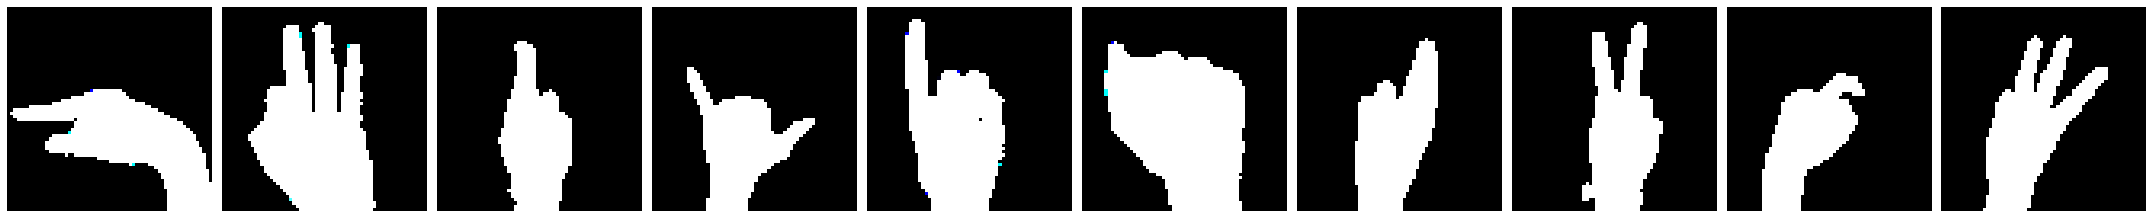

(10, 64, 64, 3)
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
  0. 0.]]


In [17]:
import matplotlib.pyplot as plt
imgs, labels = next(train_batches)
#Plotting the images...
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(30,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
plotImages(imgs)
print(imgs.shape)
print(labels)

In [6]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(64,64,3)))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'valid'))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Flatten())
model.add(Dense(64,activation ="relu"))
model.add(Dense(128,activation ="relu"))
#model.add(Dropout(0.2))
model.add(Dense(128,activation ="relu"))
#model.add(Dropout(0.3))
model.add(Dense(26,activation ="softmax"))

In [7]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 31, 31, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 15, 15, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 13, 13, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 6, 6, 128)       

In [8]:

model.compile(optimizer=SGD(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.0005)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')


model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.0001)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')

In [9]:
history2 = model.fit(train_batches, epochs=10, callbacks=[reduce_lr, early_stop],  validation_data = test_batches)

Epoch 1/10
3111/3111 [==============================] - 76s 24ms/step - loss: 0.1676 - accuracy: 0.9638 - val_loss: 0.0613 - val_accuracy: 0.9863 - lr: 0.0010
Epoch 2/10
3111/3111 [==============================] - 73s 24ms/step - loss: 0.0426 - accuracy: 0.9929 - val_loss: 1.6384e-05 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 3/10
3111/3111 [==============================] - 76s 24ms/step - loss: 0.0218 - accuracy: 0.9966 - val_loss: 1.1261e-06 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 4/10
3111/3111 [==============================] - 75s 24ms/step - loss: 6.0457e-05 - accuracy: 1.0000 - val_loss: 0.0061 - val_accuracy: 0.9959 - lr: 2.0000e-04
Epoch 5/10
3111/3111 [==============================] - 73s 23ms/step - loss: 3.1256e-04 - accuracy: 0.9999 - val_loss: 1.2166e-07 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 6/10
3111/3111 [==============================] - 73s 23ms/step - loss: 3.4253e-07 - accuracy: 1.0000 - val_loss: 4.2295e-08 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 

In [10]:
imgs, labels = next(test_batches) 

In [11]:
scores = model.evaluate(imgs, labels, verbose=0)
print(f'{model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')

loss of 0.0; accuracy of 100.0%


In [12]:
model.save('ASLmodel.h5')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

predictions on a small set of test data--

G   F   Q   X   D   A   T   U   W   V   

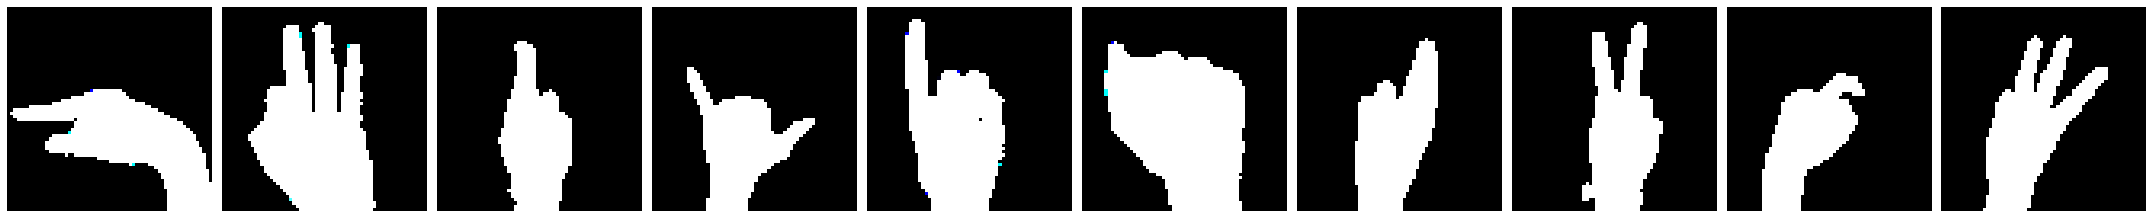

Actual labels
G   F   Q   X   D   A   T   U   W   V   

In [18]:

word_dict = {0:'A',1:'B',2:'C',3:'D',4:'E',5:'F',6:'G',7:'H',8:'I',9:'I',10:'J',11:'K',12:'L',13:'M',14:'N',15:'O',16:'P',17:'Q',18:'R',19:'S',20:'T',21:'U',22:'V',23:'W',24:'X',25:'Y',26:'Z'}
predictions = model.predict(imgs, verbose=0)
print("predictions on a small set of test data--")
print("")
for ind, i in enumerate(predictions):
    print(word_dict[np.argmax(i)], end='   ')
plotImages(imgs)
print('Actual labels')
for i in labels:
    print(word_dict[np.argmax(i)], end='   ')